In [72]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from itertools import groupby

# Fixing graphs for Justin, if this causes errors, just comment it out 
try: 
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
except ImportError:
    pass

# Preparing Data

## Loading Data

In [51]:
# Loading in the data from FILE
DATA_FILE = './six_politicians.csv'

In [54]:
# Reading the data 
df = pd.read_csv(DATA_FILE, index_col=0)

# Converting the data Created to a datetime object
df['Created'] = pd.to_datetime(df['Created'])

df.shape, df.dtypes

((2498, 8),
 Name                      object
 Username                  object
 Text                      object
 Created           datetime64[ns]
 Favorite Count             int64
 Retweet Count              int64
 Retweeted                   bool
 Media Attached              bool
 dtype: object)

In [57]:
# Displaying the list of people and their twitter handles
names_handles = zip(df['Name'].unique().tolist(), df['Username'].unique().tolist())

print(f"{'Name':>20} ---> Twitter Handle")
print('----------------------------------------')
for n, h in names_handles:
    print(f'{n:>20} ---> {h}')

                Name ---> Twitter Handle
----------------------------------------
     Donald J. Trump ---> realDonaldTrump
        Ron DeSantis ---> GovRonDeSantis
         Marco Rubio ---> marcorubio
           Joe Biden ---> JoeBiden
        Andrew Cuomo ---> NYGovCuomo
      Bernie Sanders ---> BernieSanders


In [56]:
df.head()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached
0,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-19 22:25:08,0,3060,False,False
1,Donald J. Trump,realDonaldTrump,White House News Conference at 5:45. Thank you!,2020-04-19 20:13:28,62328,12827,False,False
2,Donald J. Trump,realDonaldTrump,Thank you to my boy! https://t.co/GAFe1AdZpt,2020-04-19 19:38:09,70865,25015,False,False
3,Donald J. Trump,realDonaldTrump,“On February 19th there was a Democratic Debat...,2020-04-19 19:18:05,63158,19546,False,False
4,Donald J. Trump,realDonaldTrump,Great book by @SenatorTimScott! https://t.co/9...,2020-04-19 19:15:28,20342,5419,False,False


## Preprocessing

### Removing Keywords

In [58]:
KEYWORD_FILE = './covid_keywords.txt'

In [62]:
# Loading keywords
keywords = []

with open(KEYWORD_FILE, 'r') as f:
    line = f.readline()
    while line:
        keywords.append(line.strip())
        line = f.readline()

len(keywords), keywords[:5]

(61, ['unemployment', 'front line', 'testing', 'health', 'public health'])

In [63]:
# Making keywords regex safe then filtering df by them
safe_keywords = [re.escape(word) for word in keywords]
clean_df = df[df['Text'].str.contains('|'.join(safe_keywords))]

df.shape, clean_df.shape

((2498, 8), (977, 8))

# Analysis

## Summary Statistics

In [73]:
# counts tweets per user
def count_tweets_per_user(df):
    counts = []
    
    for user in df['Username'].unique():
        counts.append((user, df[df['Username'] == user].shape[0]))
    
    return counts

In [98]:
from itertools import groupby

# counting tweets for each user before/after filtering by keywords
num_tweets_before_filtering = count_tweets_per_user(df)
num_tweets_after_filtering = count_tweets_per_user(clean_df)

# joining the two lists together 
num_tweets_before_after = num_tweets_before_filtering + num_tweets_after_filtering

# sorting by username so users' counts are next to each other, needed for groupby
num_tweets_before_after = sorted(num_tweets_before_after)

d = groupby(num_tweets_before_after, lambda x: x[0])
counts = []

for x in d:
    f = next(x[1])[1]
    s = next(x[1])[1]
    counts.append((x[0], max(f, s), min(f, s)))

counts

[('BernieSanders', 558, 204),
 ('GovRonDeSantis', 40, 13),
 ('JoeBiden', 500, 206),
 ('NYGovCuomo', 620, 375),
 ('marcorubio', 480, 114),
 ('realDonaldTrump', 300, 65)]

## NLTK Sentiment Analysis

In [28]:
# Installs nltk if you don't have it
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [29]:
# import and download lexicon
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/user/nltk_data...


In [30]:
# Creating the Analyzer
sid = SentimentIntensityAnalyzer()

In [31]:
def sentiment(row):
    sent = sid.polarity_scores(row['Text'])
    row['pos'] = sent['pos']
    row['neg'] = sent['neg']
    row['neu'] = sent['neu']
    row['compound'] = sent['compound']
    return row

df = df.apply(lambda row: sentiment(row), axis=1)

In [32]:
#setting major_score to greater of pos/neg, if negative, multiplying by -1
df['major_score'] = df[['pos', 'neg']].apply(lambda row: row['pos'] if row['pos'] >= row['neg'] else row['neg'] * -1, axis=1)

In [33]:
df.head()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached,pos,neg,neu,compound,major_score
0,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-19 22:25:08,0,3060,False,False,0.0,0.000,1.000,0.0000,0.000
10,Donald J. Trump,realDonaldTrump,RT @RepLeeZeldin: While @realDonaldTrump belie...,2020-04-19 18:11:27,0,5934,False,False,0.0,0.280,0.720,-0.7906,-0.280
12,Donald J. Trump,realDonaldTrump,RT @kimguilfoyle: “In responding to the outbre...,2020-04-19 18:08:54,0,3917,False,False,0.0,0.000,1.000,0.0000,0.000
16,Donald J. Trump,realDonaldTrump,RT @DonaldJTrumpJr: Germany’s largest newspape...,2020-04-19 17:34:39,0,18608,False,False,0.0,0.000,1.000,0.0000,0.000
17,Donald J. Trump,realDonaldTrump,RT @ArthurSchwartz: She calls it “the flu” and...,2020-04-19 17:33:49,0,8129,False,False,0.0,0.143,0.857,-0.6124,-0.143


# Vizualizing Data

In [35]:
trump_df = df[df['Username'] == 'realDonaldTrump'].sort_values('Created')
biden_df = df[df['Username'] == 'JoeBiden'].sort_values('Created')
trump_df.shape, biden_df.shape

((65, 13), (206, 13))

In [36]:
trump_df.tail()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached,pos,neg,neu,compound,major_score
17,Donald J. Trump,realDonaldTrump,RT @ArthurSchwartz: She calls it “the flu” and...,2020-04-19 17:33:49,0,8129,False,False,0.0,0.143,0.857,-0.6124,-0.143
16,Donald J. Trump,realDonaldTrump,RT @DonaldJTrumpJr: Germany’s largest newspape...,2020-04-19 17:34:39,0,18608,False,False,0.0,0.000,1.000,0.0000,0.000
12,Donald J. Trump,realDonaldTrump,RT @kimguilfoyle: “In responding to the outbre...,2020-04-19 18:08:54,0,3917,False,False,0.0,0.000,1.000,0.0000,0.000
10,Donald J. Trump,realDonaldTrump,RT @RepLeeZeldin: While @realDonaldTrump belie...,2020-04-19 18:11:27,0,5934,False,False,0.0,0.280,0.720,-0.7906,-0.280
0,Donald J. Trump,realDonaldTrump,RT @WhiteHouse: LIVE: Press Briefing with Coro...,2020-04-19 22:25:08,0,3060,False,False,0.0,0.000,1.000,0.0000,0.000


In [37]:
trump_df.describe()

,Favorite Count,Retweet Count,pos,neg,neu,compound,major_score
count,65.000000,65.00000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,56729.723077,21208.00000,0.077538,0.089508,0.832938,-0.037378,-0.015738
std,98701.075128,20020.08351,0.094118,0.102490,0.131894,0.492538,0.173812
min,0.000000,2957.00000,0.000000,0.000000,0.555000,-0.928600,-0.399000
25%,0.000000,7547.00000,0.000000,0.000000,0.741000,-0.440400,-0.143000
50%,0.000000,13417.00000,0.042000,0.075000,0.839000,0.000000,0.000000
75%,115737.000000,31819.00000,0.143000,0.143000,0.958000,0.361200,0.111000
max,444327.000000,97998.00000,0.354000,0.399000,1.000000,0.834400,0.354000


In [38]:
biden_df.describe()

,Favorite Count,Retweet Count,pos,neg,neu,compound,major_score
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,35634.713592,8375.179612,0.105005,0.113655,0.781306,-0.037483,-0.005650
std,41609.869052,8297.075020,0.086678,0.097554,0.110789,0.577714,0.188782
min,0.000000,241.000000,0.000000,0.000000,0.455000,-0.937900,-0.486000
25%,9873.250000,2802.250000,0.035250,0.041250,0.716000,-0.619450,-0.158750
50%,21492.500000,5720.500000,0.099000,0.100500,0.774000,0.000000,0.000000
75%,43908.750000,11139.750000,0.160750,0.160000,0.856000,0.435675,0.154000
max,281889.000000,48069.000000,0.404000,0.486000,1.000000,0.963300,0.404000


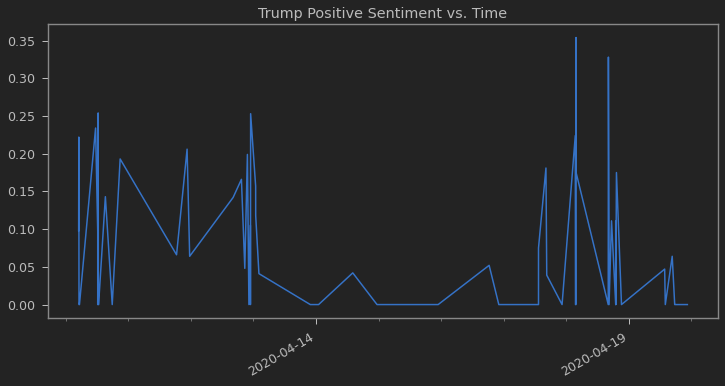

In [39]:
# trump tweets 
fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Trump Positive Sentiment vs. Time')
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.plot(trump_df['Created'], trump_df['pos'])

fig.autofmt_xdate()

plt.show()

In [ ]:
# biden tweets
fig, ax = plt.subplots( figsize=(12,6))

ax.set_title('Biden Positive Sentiment vs. Time')
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.plot(biden_df['Created'], biden_df['pos'])

fig.autofmt_xdate()

plt.show()

In [ ]:
# plotting positive and neg scores, whichever is greater
trump_pos = trump_df.copy()
trump_neg = trump_df.copy()

trump_pos['major_score'] = trump_pos['major_score'].apply(lambda val: val if val >= 0 else np.nan)
trump_neg['major_score'] = trump_neg['major_score'].apply(lambda val: val if val < 0 else np.nan)


fig, ax = plt.subplots( figsize=(12,6))
ax.bar(trump_pos['Created'], trump_pos['major_score'])
ax.bar(trump_neg['Created'], trump_neg['major_score'], color='r')

plt.show()